# Network Analysis Summary

This notebook analyzes the synthetic Boolean networks, examining:
- Number of attractors
- Other SCCs (non-attractor)
- Parentless nodes
- SCC interconnection structure

In [27]:
import os
import sys
from pathlib import Path
from collections import defaultdict
import pandas as pd
import importlib.util

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

In [29]:
def load_network(filepath):
    """Load a network from a Python file."""
    spec = importlib.util.spec_from_file_location("network", filepath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    
    if hasattr(module, 'transitions'):
        return module.transitions, getattr(module, 'network_functions', None)
    elif hasattr(module, 'network_functions'):
        # Need to compute transitions from functions
        return None, module.network_functions
    return None, None

In [30]:
def find_sccs(transitions):
    """Find strongly connected components using iterative Tarjan's algorithm."""
    index_counter = [0]
    stack = []
    lowlinks = {}
    index = {}
    on_stack = {}
    sccs = []
    
    for start_node in transitions:
        if start_node in index:
            continue
        
        call_stack = [(start_node, None, 0)]
        
        while call_stack:
            node, successor_iter, phase = call_stack.pop()
            
            if phase == 0:
                index[node] = index_counter[0]
                lowlinks[node] = index_counter[0]
                index_counter[0] += 1
                stack.append(node)
                on_stack[node] = True
                successor_iter = iter(transitions.get(node, []))
                call_stack.append((node, successor_iter, 1))
            else:
                try:
                    successor = next(successor_iter)
                    call_stack.append((node, successor_iter, 1))
                    if successor not in index:
                        call_stack.append((successor, None, 0))
                    elif on_stack.get(successor, False):
                        lowlinks[node] = min(lowlinks[node], index[successor])
                except StopIteration:
                    if lowlinks[node] == index[node]:
                        scc = set()
                        while True:
                            successor = stack.pop()
                            on_stack[successor] = False
                            scc.add(successor)
                            if successor == node:
                                break
                        sccs.append(scc)
                    if call_stack:
                        parent_node = call_stack[-1][0]
                        if parent_node in lowlinks:
                            lowlinks[parent_node] = min(lowlinks[parent_node], lowlinks[node])
    return sccs

In [31]:
def analyze_network(transitions):
    """Analyze network structure."""
    all_states = set(transitions.keys())
    
    # Find all target states
    all_targets = set()
    for targets in transitions.values():
        all_targets.update(targets)
    
    # Parentless states (no incoming edges)
    parentless = all_states - all_targets
    
    # Fixed points (self-loops only)
    fixed_points = [s for s, targets in transitions.items() if targets == [s]]
    
    # Find SCCs
    sccs = find_sccs(transitions)
    
    # Identify attractors (SCCs with no exit)
    attractors = []
    transient_sccs = []
    
    for scc in sccs:
        has_exit = False
        for state in scc:
            for target in transitions.get(state, []):
                if target not in scc:
                    has_exit = True
                    break
            if has_exit:
                break
        if not has_exit:
            attractors.append(scc)
        else:
            transient_sccs.append(scc)
    
    # Build SCC graph (condensation)
    state_to_scc = {}
    for i, scc in enumerate(sccs):
        for state in scc:
            state_to_scc[state] = i
    
    scc_edges = set()
    for state, targets in transitions.items():
        src_scc = state_to_scc[state]
        for target in targets:
            dst_scc = state_to_scc[target]
            if src_scc != dst_scc:
                scc_edges.add((src_scc, dst_scc))
    
    return {
        'num_states': len(all_states),
        'num_transitions': sum(len(t) for t in transitions.values()),
        'parentless_states': len(parentless),
        'fixed_points': len(fixed_points),
        'num_sccs': len(sccs),
        'num_attractors': len(attractors),
        'attractor_sizes': sorted([len(a) for a in attractors], reverse=True),
        'num_transient_sccs': len(transient_sccs),
        'transient_scc_sizes': sorted([len(s) for s in transient_sccs], reverse=True)[:10],
        'scc_edges': len(scc_edges),
    }

In [42]:
# Load selected networks from CSV
selected_networks_csv = Path.cwd() / 'networks_selected_for_analysis.csv'
with open(selected_networks_csv) as f:
    selected_filenames = set(line.strip() for line in f if line.strip())

print(f"Selected networks from CSV: {len(selected_filenames)}")

# Discover networks (only those in the CSV)
base_dir = Path.cwd()
exclude_dirs = {'biodivine', '7d_generated'}

networks = []
for subdir in sorted(base_dir.iterdir()):
    if subdir.is_dir() and subdir.name not in exclude_dirs and not subdir.name.startswith('.'):
        for pyfile in sorted(subdir.glob('*.py')):
            if pyfile.name in selected_filenames:
                networks.append({
                    'directory': subdir.name,
                    'filename': pyfile.name,
                    'path': pyfile
                })

print(f"Found {len(networks)} networks to analyze")
print(f"\nDirectories: {sorted(set(n['directory'] for n in networks))}")

Selected networks from CSV: 22
Found 22 networks to analyze

Directories: ['10d_3dep', '5d_interesting', '6d_3dep', '7d_3dep', '8d_3dep', '9d_3dep']


In [43]:
# Analyze all networks
import re

results = []

for net in networks:
    try:
        transitions, functions = load_network(net['path'])
        if transitions is None:
            print(f"Skipping {net['filename']}: no transitions found")
            continue
        
        analysis = analyze_network(transitions)
        
        # Extract dimension from directory name
        dim_match = net['directory'].split('d')[0]
        dim = int(''.join(filter(str.isdigit, dim_match))) if dim_match else 0
        
        # Extract seed from filename (e.g., bn_7d_3dep_seed_26.py -> 26)
        seed_match = re.search(r'seed[_-]?(\d+)', net['filename'])
        if seed_match:
            seed = int(seed_match.group(1))
        else:
            # Try to extract any number from filename as fallback (e.g., bn_fn_5d_net_1_fixed.py -> 1)
            num_match = re.search(r'net[_-]?(\d+)', net['filename'])
            seed = int(num_match.group(1)) if num_match else 0
        
        results.append({
            'dimension': dim,
            'seed': seed,
            'directory': net['directory'],
            'network': net['filename'],
            **analysis
        })
    except Exception as e:
        print(f"Error analyzing {net['filename']}: {e}")

print(f"\nSuccessfully analyzed {len(results)} networks")


Successfully analyzed 22 networks


In [44]:
# Create summary DataFrame
df = pd.DataFrame(results)

# Display summary
summary_cols = ['dimension', 'seed', 'num_states', 'parentless_states', 
                'fixed_points', 'num_attractors', 'num_transient_sccs', 'scc_edges']
df[summary_cols]

,dimension,seed,num_states,parentless_states,fixed_points,num_attractors,num_transient_sccs,scc_edges
0,10,101,1024,0,0,1,23,96
1,10,202,1024,1,3,4,163,697
2,10,303,1024,1,0,2,219,1156
3,5,1,32,2,2,2,30,80
4,5,2,32,1,1,1,31,80
5,5,3,32,1,1,1,31,80
6,5,4,32,1,1,1,31,80
7,5,5,32,1,2,2,30,80
8,6,101,64,0,2,3,20,57
9,6,202,64,0,0,1,0,0


In [37]:
# Detailed attractor information
print("=" * 80)
print("ATTRACTOR DETAILS")
print("=" * 80)

for _, row in df.iterrows():
    print(f"\n{row['directory']}/{row['network']}")
    print(f"  Dimension: {row['dimension']}D ({row['num_states']} states)")
    print(f"  Parentless states: {row['parentless_states']}")
    print(f"  Fixed points: {row['fixed_points']}")
    print(f"  Attractors: {row['num_attractors']} (sizes: {row['attractor_sizes']})")
    print(f"  Transient SCCs: {row['num_transient_sccs']}")
    if row['transient_scc_sizes']:
        print(f"  Largest transient SCCs: {row['transient_scc_sizes']}")
    print(f"  SCC interconnections: {row['scc_edges']} edges")

ATTRACTOR DETAILS

10d_3dep/bn_10d_3dep_seed_101.py
  Dimension: 10D (1024 states)
  Parentless states: 0
  Fixed points: 0
  Attractors: 1 (sizes: [956])
  Transient SCCs: 23
  Largest transient SCCs: [32, 4, 4, 4, 4, 2, 2, 1, 1, 1]
  SCC interconnections: 96 edges

10d_3dep/bn_10d_3dep_seed_202.py
  Dimension: 10D (1024 states)
  Parentless states: 1
  Fixed points: 3
  Attractors: 4 (sizes: [2, 1, 1, 1])
  Transient SCCs: 163
  Largest transient SCCs: [326, 229, 48, 28, 24, 24, 24, 24, 7, 7]
  SCC interconnections: 697 edges

10d_3dep/bn_10d_3dep_seed_303.py
  Dimension: 10D (1024 states)
  Parentless states: 1
  Fixed points: 0
  Attractors: 2 (sizes: [512, 2])
  Transient SCCs: 219
  Largest transient SCCs: [24, 24, 16, 16, 8, 8, 8, 8, 8, 8]
  SCC interconnections: 1156 edges

10d_3dep/bn_10d_3dep_seed_404.py
  Dimension: 10D (1024 states)
  Parentless states: 0
  Fixed points: 1
  Attractors: 2 (sizes: [2, 1])
  Transient SCCs: 119
  Largest transient SCCs: [742, 64, 16, 16, 14, 

In [38]:
# Summary statistics by dimension
print("\n" + "=" * 80)
print("SUMMARY BY DIMENSION")
print("=" * 80)

dim_summary = df.groupby('dimension').agg({
    'network': 'count',
    'num_states': 'first',
    'parentless_states': 'mean',
    'num_attractors': 'mean',
    'fixed_points': 'mean',
    'num_transient_sccs': 'mean',
    'scc_edges': 'mean'
}).rename(columns={'network': 'count'})

dim_summary.round(2)


SUMMARY BY DIMENSION


,count,num_states,parentless_states,num_attractors,fixed_points,num_transient_sccs,scc_edges
dimension,,,,,,,
5,5,32,1.2,1.4,1.4,30.6,80.0
6,5,64,1.0,1.8,1.2,23.2,65.8
7,5,128,2.2,3.2,2.0,44.4,134.2
8,5,256,1.0,1.4,0.2,13.8,41.2
9,5,512,0.6,1.2,0.6,37.2,132.8
10,5,1024,0.8,2.0,0.8,106.4,497.4
11,5,2048,1.0,2.2,1.8,256.4,1349.0
12,5,4096,1.0,1.2,0.6,389.2,2362.8
13,5,8192,0.4,1.2,0.6,101.0,450.2


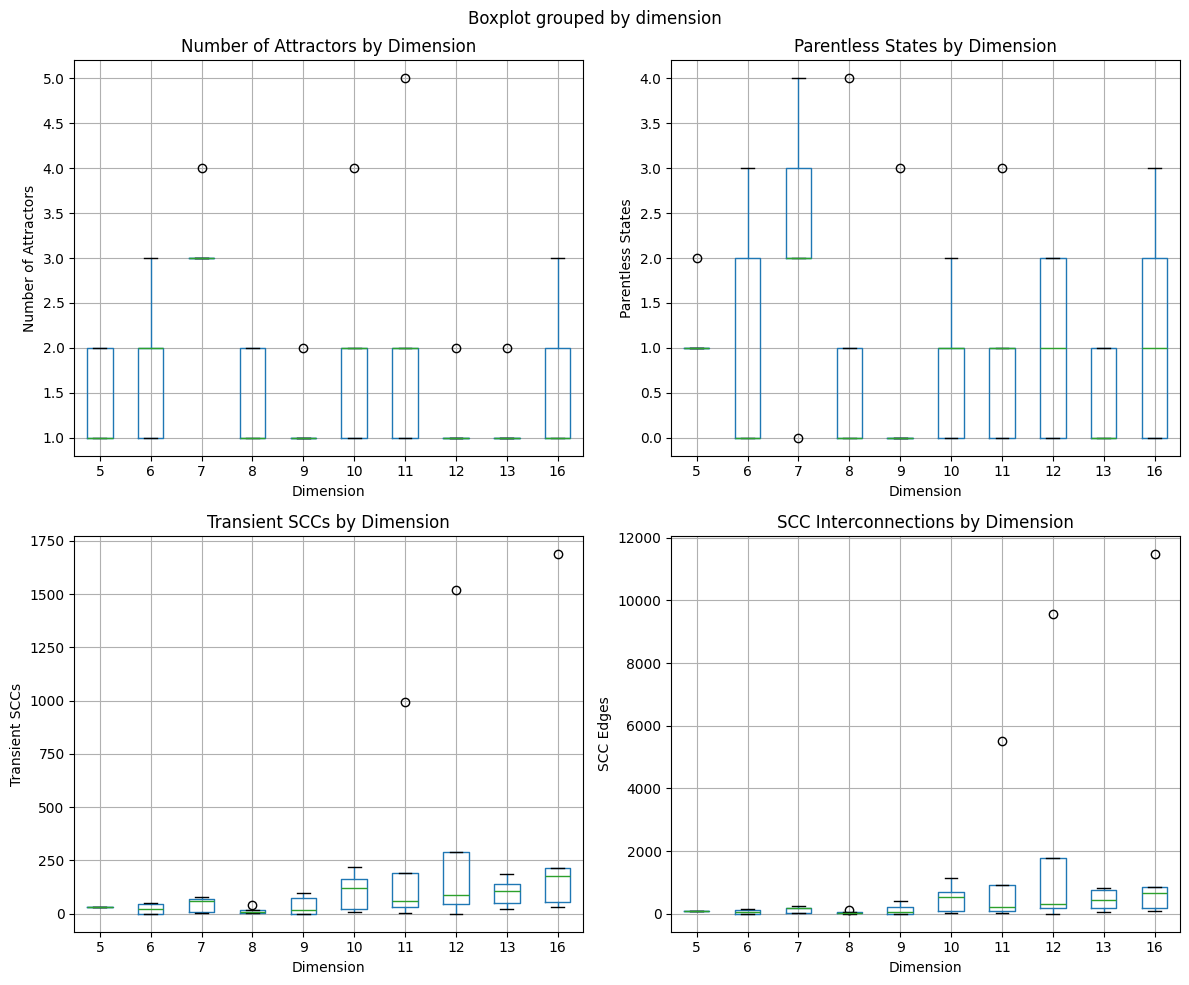

In [40]:
# Visualize attractor distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Attractors by dimension
ax1 = axes[0, 0]
df.boxplot(column='num_attractors', by='dimension', ax=ax1)
ax1.set_title('Number of Attractors by Dimension')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Number of Attractors')
plt.suptitle('')

# Parentless states by dimension
ax2 = axes[0, 1]
df.boxplot(column='parentless_states', by='dimension', ax=ax2)
ax2.set_title('Parentless States by Dimension')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Parentless States')

# Transient SCCs by dimension
ax3 = axes[1, 0]
df.boxplot(column='num_transient_sccs', by='dimension', ax=ax3)
ax3.set_title('Transient SCCs by Dimension')
ax3.set_xlabel('Dimension')
ax3.set_ylabel('Transient SCCs')

# SCC interconnections by dimension
ax4 = axes[1, 1]
df.boxplot(column='scc_edges', by='dimension', ax=ax4)
ax4.set_title('SCC Interconnections by Dimension')
ax4.set_xlabel('Dimension')
ax4.set_ylabel('SCC Edges')

plt.tight_layout()
plt.show()

In [45]:
# Save results to CSV (excluding directory and network columns)
output_path = base_dir / 'network_analysis_results.csv'
df_export = df.drop(columns=['directory', 'network'], errors='ignore')
df_export.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to /Users/marcinnowakowski/mimuw/sad2/boolean_bayesian_networks/networks/functions/network_analysis_results.csv
